In [10]:
import os, glob, sqlite3
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [11]:
os.makedirs("Google Play Store Dataset", exist_ok=True)
Dataset_Path = os.path.join("Google Play Store Dataset", "Google Play Store Dataset.csv")

In [12]:
Store = pd.read_csv(Dataset_Path)

In [13]:
class Dataset_Cleanning:
    def __init__(self, Dataset):
        self.Dataset = Dataset.copy().dropna()
        self.Cleaned_Dataset = self.Data_cleaning()
    
    def Data_cleaning(self):
        self.Dataset['Category'] = self.Dataset['Category'].apply(lambda x: x.replace('_', ' ').title())
        self.Dataset['App Size'] = self.Dataset['App Size'].apply(
            lambda x: float(x.replace('M', '')) if 'M' in x 
            else np.nan if x == 'Varies with device' 
            else float(x.replace('k', '')) / 1024
        )
        self.Dataset['App Size'] = self.Dataset['App Size'].fillna(int(self.Dataset['App Size'].mean()))
        self.Dataset['Last Updated'] = pd.to_datetime(self.Dataset['Last Updated'], format='%B %d, %Y', errors='coerce').dt.strftime('%d-%m-%Y')
        self.Dataset['Price'] = self.Dataset['Price'].apply(lambda x: 0 if x == 'Free' else float(x.strip('$')))    
             
        self.Dataset.to_csv(os.path.join("Google Play Store Dataset", "Power BI Dataset.csv"), header=True, index=False, encoding="utf-8-sig")
        return self.Dataset


In [14]:
class SQLite3:
    def __init__(self, Dataset , Name):
        self.Dataset = Dataset
        self.Name = Name
        
    def SQLite3_Connection(self):
        if self.Name + ".db" not in glob.glob("*db"):
            Connection = sqlite3.connect(self.Name + ".db")
            self.Dataset.to_sql(self.Name, Connection, if_exists='replace', index=False)
            print("Database already created!")
            return Connection
        else: return sqlite3.connect(self.Name + ".db")

    def Exc(self, Query):
        Connection = self.SQLite3_Connection()
        return pd.read_sql_query(Query, Connection)
    
Conn = SQLite3(Dataset_Cleanning(Store).Cleaned_Dataset, 'Google Play Store Application')
Query = """
    SELECT * 
    FROM 'Google Play Store Application'
"""        
Conn.Exc(Query)

,App,Category,Rating,Reviews,App Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,Art And Design,4.1,159,19.0,"10,000+",Free,0.0,Everyone,Art & Design,07-01-2018,1.0.0,4.0.3 and up
1,Coloring book moana,Art And Design,3.9,967,14.0,"500,000+",Free,0.0,Everyone,Art & Design;Pretend Play,15-01-2018,2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",Art And Design,4.7,87510,8.7,"5,000,000+",Free,0.0,Everyone,Art & Design,01-08-2018,1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,Art And Design,4.5,215644,25.0,"50,000,000+",Free,0.0,Teen,Art & Design,08-06-2018,Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,Art And Design,4.3,967,2.8,"100,000+",Free,0.0,Everyone,Art & Design;Creativity,20-06-2018,1.1,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9355,FR Calculator,Family,4.0,7,2.6,500+,Free,0.0,Everyone,Education,18-06-2017,1.0.0,4.1 and up
9356,Sya9a Maroc - FR,Family,4.5,38,53.0,"5,000+",Free,0.0,Everyone,Education,25-07-2017,1.48,4.1 and up
9357,Fr. Mike Schmitz Audio Teachings,Family,5.0,4,3.6,100+,Free,0.0,Everyone,Education,06-07-2018,1.0,4.1 and up
9358,The SCP Foundation DB fr nn5n,Books And Reference,4.5,114,22.0,"1,000+",Free,0.0,Mature 17+,Books & Reference,19-01-2015,Varies with device,Varies with device


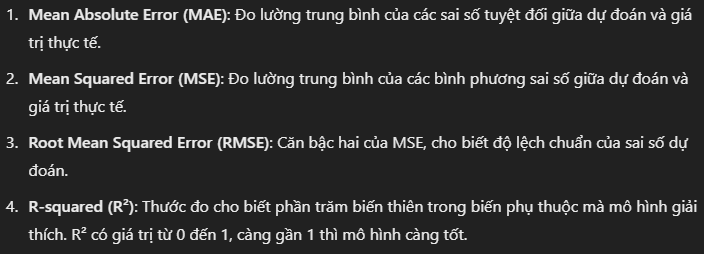

In [16]:
class Rating_Prediction_Model:
    def __init__(self, Dataset):
        self.X_train, self.X_test, self.Y_train, self.Y_test = self.Data_Preparation(Dataset)
        self.Model = self.Build_Model()
        self.Model.fit(self.X_train, self.Y_train, epochs=20, batch_size=32)  # Huấn luyện mô hình

    def Data_Preparation(self, Dataset):
        X = Dataset.drop(['Rating', 'Category', 'Reviews', 'Content Rating', 'Genres', 'Last Updated'], axis=1)
        Y = Dataset['Rating'].astype(float)

        # Chuyển dữ liệu phân loại thành mã số (One-hot encoding)
        X = pd.get_dummies(X, drop_first=True)

        # Chuẩn hóa dữ liệu đầu vào
        self.scaler = StandardScaler()  # Lưu scaler để sử dụng sau này
        X = self.scaler.fit_transform(X)

        # Định hình lại dữ liệu cho LSTM (samples, timesteps, features)
        X = X.reshape((X.shape[0], 1, X.shape[1]))

        # Chia dữ liệu thành tập huấn luyện và kiểm tra
        return train_test_split(X, Y, test_size=0.2, random_state=42)

    def Build_Model(self):
        model = Sequential()
        model.add(LSTM(64, input_shape=(1, self.X_train.shape[2]), return_sequences=True))
        model.add(Dropout(0.5))
        model.add(LSTM(32))
        model.add(Dense(1, activation='linear'))

        model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
        return model

    def Predict(self, new_data):
        # Tiền xử lý dữ liệu mới
        new_data = new_data.drop(['Category', 'Reviews', 'Content Rating', 'Genres', 'Last Updated'], axis=1)
        new_data = pd.get_dummies(new_data, drop_first=True)

        # Đảm bảo rằng dữ liệu mới có cùng cấu trúc với dữ liệu huấn luyện
        new_data = new_data.reindex(columns=self.scaler.get_feature_names_out(), fill_value=0)

        # Chuẩn hóa dữ liệu mới
        new_data = self.scaler.transform(new_data)

        # Định hình lại dữ liệu cho LSTM
        new_data = new_data.reshape((new_data.shape[0], 1, new_data.shape[1]))

        # Dự đoán xếp hạng
        predictions = self.Model.predict(new_data)
        return predictions

# Khởi tạo mô hình và huấn luyện
model = Rating_Prediction_Model(Dataset_Cleanning(Store).Cleaned_Dataset)


Epoch 1/20
234/234 [==============================] - 3s 6ms/step - loss: 9.5752 - mae: 2.7197
Epoch 2/20
234/234 [==============================] - 1s 6ms/step - loss: 2.0521 - mae: 0.9801
Epoch 3/20
234/234 [==============================] - 1s 6ms/step - loss: 0.6704 - mae: 0.5679
Epoch 4/20
234/234 [==============================] - 1s 6ms/step - loss: 0.3163 - mae: 0.4014
Epoch 5/20
234/234 [==============================] - 1s 6ms/step - loss: 0.2101 - mae: 0.3251
Epoch 6/20
234/234 [==============================] - 1s 6ms/step - loss: 0.1647 - mae: 0.2870
Epoch 7/20
234/234 [==============================] - 1s 6ms/step - loss: 0.1355 - mae: 0.2622
Epoch 8/20
234/234 [==============================] - 1s 6ms/step - loss: 0.1171 - mae: 0.2437
Epoch 9/20
234/234 [==============================] - 1s 6ms/step - loss: 0.1017 - mae: 0.2268
Epoch 10/20
234/234 [==============================] - 1s 6ms/step - loss: 0.0906 - mae: 0.2142
Epoch 11/20
234/234 [============================

In [19]:
new_data = pd.DataFrame({
    'App': ['App A'],
    'Category': ['Art And Design'],
    'Reviews': [87510],
    'App Size': [25.0],
    'Installs': [50000],    
    'Type': ['Free'],
    'Price': [0],    
    'Content Rating': ['Everyone'],
    'Genres':['Art & Design'],
    'Last Updated': ['2024-10-29'],
    'Current Ver': ['1.9.2'],
    'Android Ver': ['4.1 and up']
})

predictions = model.Predict(new_data)
print("Dự đoán xếp hạng ứng dụng:", round(predictions.flatten()[0], 1))

1/1 [==============================] - 0s 21ms/step
Dự đoán xếp hạng ứng dụng: 4.3
